# 2.1 Library Setup & Data Loading

In [1]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Libraries for Automated "First Pass" Scan
from ydata_profiling import ProfileReport

In [2]:
# Libraries for Redundancy Analysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

In [2]:
# Libraries for Feature Selection
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Libraries for Segmentation via UMAP
import umap
from sklearn.preprocessing import StandardScaler

In [34]:
# Libraries for Statistical Analysis
from scipy.stats import normaltest, skew, kurtosis

In [4]:
# Load The Training Dataset
train_df = pd.read_parquet('../data/processed/train_df.parquet', engine='fastparquet')
print(f"Training DataFrame Shape: {train_df.shape}")

Training DataFrame Shape: (52004, 140)


# 2.2 Automated "First Pass" & Data Health

This paper discusses the necessity of automated tools to handle the "scale and complexity of modern data," which traditional manual EDA cannot.
* Gaikwad, J., et al. (2024). AI-based exploratory data analysis. International Journal of Scientific Research in Computer Science, Engineering and Information Technology, 11(2), 3876–3884. https://doi.org/10.32628/CSEIT25112860

In [3]:
# Automated Profiling Report
# Identify missing values, zeros, and high correlations instantly
profile = ProfileReport(train_df, title="Telco Churn Data Health Check", minimal=True)
profile.to_file('../reports/data_health_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:10<00:00, 13.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Check for Zero Variance
zero_var_cols = [col for col in train_df.columns if train_df[col].nunique() <= 1]

if len(zero_var_cols) == 0:
    print("Confirmed: No columns with zero variance. Every feature has data.")
else:
    print(f"Found {len(zero_var_cols)} columns with zero variance: {zero_var_cols}")

Confirmed: No columns with zero variance. Every feature has data.


### Data Profiling & Health Check Summary
**Objective:** assessed data quality, sparsity, and distribution properties.

**Key Findings:**
* **Data Integrity:** The dataset contains no missing values and no zero-variance columns.
* **Cardinality:** `customer_id` acts as a unique key and will be removed. Several continuous features (e.g., `spend_change_2wk`) exhibit 100% cardinality (unique values per user), which is expected for high-precision calculated metrics.
* **Correlations:** The initial automated scan (in minimal mode) suppressed correlation computations. **Action Taken:** A manual Spearman correlation analysis will be performed (see next section), confirming strong monotonic relationships between base app usage and aggregate data features.
* **Target Variable:** The churn rate is **23.1%**, requiring recall-oriented evaluation metrics or threshold-independent metrics (AUC-ROC) rather than accuracy.
* **Sparsity:** High-sparsity features contain ~40% zeros, supporting the use of **Weight of Evidence (WoE)** binning.
* **Distribution:** Significant skewness was observed in `distinct_services_w1_2` ($\gamma_1 \approx -131$), indicating a highly concentrated user behavior pattern that will require non-linear transformation or binning (depending on which algorithm selected).

**Action Taken:**
* Dropped identifier column (`customer_id`).
* Proceeding to **Hierarchical Clustering** to visualize feature redundancy.

# 2.3 Redundancy Analysis

These papers emphasize redundancy analysis with hierarchical flustering of features (dendrograms) to handle the curse of dimensionality
* Jambekar, P., & Nandi, S. (2022). Mitigating the multicollinearity problem and its machine learning approach: A review. Mathematics, 10(8), 1283. https://doi.org/10.3390/math10081283
* Chavent, M., Kuentz-Simonet, V., Labenne, A., & Saracco, J. (2022). Hierarchical clustering: Visualization, feature importance and model selection. Computational Statistics, 37, 1–25. https://doi.org/10.1016/j.asoc.2023.110303

In [10]:
# Drop ONLY customer_id
train_df.drop(columns=['customer_id'], inplace=True)

Manual Check: Correlation between Total Data and YouTube is: 0.5844


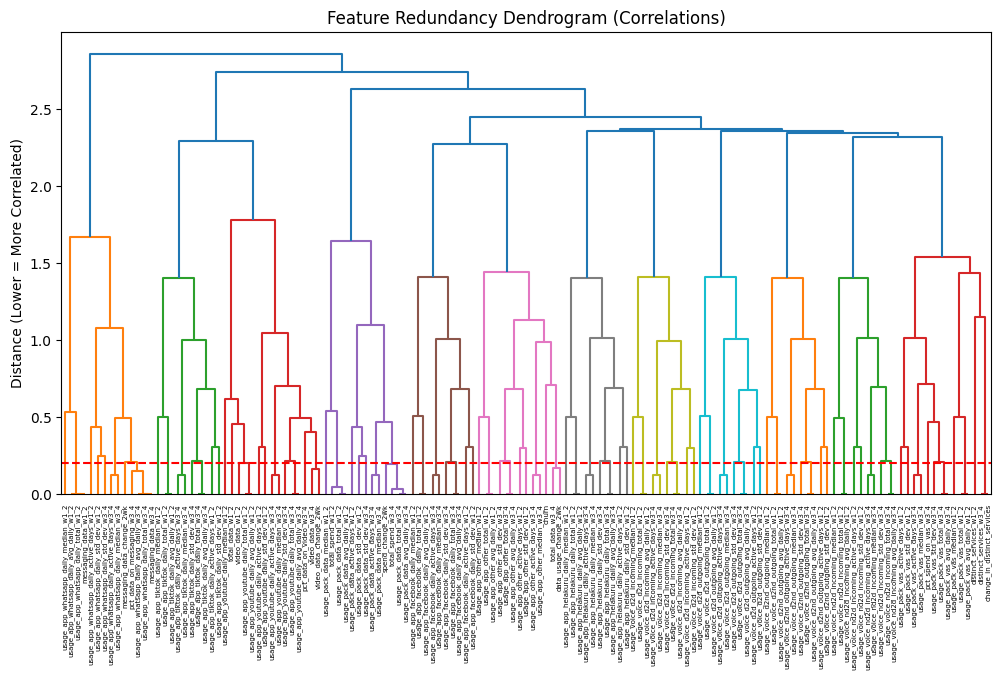

In [8]:
# Calculate Spearman Correlation
# This captures non-linear relationships better than the Profiling Report
corr_matrix = train_df.corr(method='spearman')

# Quick Logic Check:
# Verify the specific relationship between two columns with potential high correlation
check_val = corr_matrix.loc['total_data_w1_2', 'usage_app_youtube_daily_total_w1_2']
print(f"Manual Check: Correlation between Total Data and YouTube is: {check_val:.4f}")

# Visualization: Hierarchical Clustering (Dendrogram)
plt.figure(figsize=(12, 6))
# Convert correlation to distance
# If two features are not correlated at all (0), they are totally different.
# The distance should be 1 (or maximum)
dist_matrix = 1 - np.abs(corr_matrix)
clustering = linkage(squareform(dist_matrix), method='ward')

dendrogram(clustering, labels=train_df.columns, leaf_rotation=90)
plt.title("Feature Redundancy Dendrogram (Correlations)")
plt.ylabel("Distance (Lower = More Correlated)")
plt.axhline(y=0.2, color='r', linestyle='--', label='High Redundancy Threshold')

# Save the figure
plt.savefig('../reports/figures/redundancy_dendrogram.png', bbox_inches='tight')

plt.show()

*Notes:*
* *Total Data and YouTube Data are related, but not identical. There are likely many users who use high data without using YouTube (Maybe TikTok). We keep features with correlation like this since they tell different stories.*
* *The dendrogram is too huge to read. We will use a technique called "Cutting the Tree" and tell Python: "If any features are connected effectively at the ankles (extremely similar, distance < 0.2), group them together and inform me."*

In [7]:
# Cut the dendrogram to find clusters of identical features
# t=0.2 means "Only group features that are >80% similar (Spearman)"
# We can adjust t: 0.1 is very strict (must be almost identical), 0.5 is loose.
clusters = fcluster(clustering, t=0.2, criterion='distance')

# Create a DataFrame to view the groups
cluster_df = pd.DataFrame({'Feature': train_df.columns, 'Cluster': clusters})

# Find clusters that have more than 1 feature (Redundant Groups)
redundant_groups = cluster_df.groupby('Cluster').filter(lambda x: len(x) > 1)

# Print the results
if len(redundant_groups) == 0:
    print("No highly redundant features found (at threshold 0.2).")
    print("This means the engineered features are distinct enough to keep!")
else:
    print(f"Found {redundant_groups['Cluster'].nunique()} groups of redundant features.")
    print("Here are the features that are basically copies of each other:\n")
    
    for cluster_id in redundant_groups['Cluster'].unique():
        features_in_group = redundant_groups[redundant_groups['Cluster'] == cluster_id]['Feature'].tolist()
        print(f"Group {cluster_id}: {features_in_group}")
        # Keep the simplest one, drop the others.

Found 39 groups of redundant features.
Here are the features that are basically copies of each other:

Group 34: ['usage_app_facebook_daily_total_w1_2', 'usage_app_facebook_daily_avg_daily_w1_2']
Group 37: ['usage_app_facebook_daily_total_w3_4', 'usage_app_facebook_daily_avg_daily_w3_4']
Group 36: ['usage_app_facebook_daily_active_days_w3_4', 'usage_app_facebook_daily_median_w3_4']
Group 16: ['usage_app_youtube_daily_total_w1_2', 'usage_app_youtube_daily_avg_daily_w1_2']
Group 23: ['usage_app_youtube_daily_total_w3_4', 'usage_app_youtube_daily_avg_daily_w3_4']
Group 22: ['usage_app_youtube_daily_active_days_w3_4', 'usage_app_youtube_daily_median_w3_4']
Group 9: ['usage_app_tiktok_daily_total_w1_2', 'usage_app_tiktok_daily_avg_daily_w1_2']
Group 12: ['usage_app_tiktok_daily_total_w3_4', 'usage_app_tiktok_daily_avg_daily_w3_4']
Group 11: ['usage_app_tiktok_daily_active_days_w3_4', 'usage_app_tiktok_daily_median_w3_4']
Group 1: ['usage_app_whatsapp_daily_total_w1_2', 'usage_app_whatsapp_d

### Redundancy Analysis (Hierarchical Clustering) Summary
**Objective:** Identify collinear features to prevent model instability and simplify dimensionality.

**Method:** Performed Hierarchical Clustering (Ward's Linkage) using a Spearman correlation matrix to detect non-linear dependencies.

**Key Findings:**
* **High Multicollinearity:** Identified **39 groups** of highly redundant features (Spearman correlation > 0.8 / Distance < 0.2).
* **Source of Redundancy:** The majority of overlaps stem from mathematical coupling between engineered aggregates. For example, `Total Usage` and `Average Daily Usage` are mathematically distinct but provide identical variance signals for apps like Facebook and YouTube.
* **Feature Clusters:** Distinct clusters were observed grouping "Volume" metrics (Total/Avg) separately from "Engagement" metrics (Active Days) in some cases, but heavily overlapping in others.

**Action Taken:**
* **Strategy:** Adopted a **"Flag and Validate"** approach.
* **Decision:** Instead of immediate removal, all redundant variants are **retained** for the next phase (Feature Importance). This allows for an empirical comparison to determine whether "Volume" (Total MB) or "Frequency" (Active Days) is the superior predictor of churn before final pruning.

# 2.4 Feature Engineering

## 2.4.1 Information Value (IV)

This recent study demonstrates the application of WoE and IV for feature selection and predictive modeling in a heavy-industry business context.
* Rêma, G. S., Soares, R. M., Bonatto, B. D., & de Lima, A. C. S. (2024). Data analysis methodology utilizing the statistical metrics Weight of Evidence (WoE) and Information Value (IV) to assist in asset management of power transformers. IEEE Access, 12, 1-14. https://doi.org/10.1109/ACCESS.2024.3493876

In [5]:
def calculate_iv(df, feature, target):
    # Create a lightweight copy
    df_temp = df[[feature, target]].copy()
    
    # Handle Numeric vs Categorical Logic
    # If numeric and has many unique values, we bin it.
    if np.issubdtype(df_temp[feature].dtype, np.number) and df_temp[feature].nunique() > 10:
        try:
            # Create bins. Use str() to ensure the resulting series is compatible with 'Missing' text later
            df_temp['group'] = pd.qcut(df_temp[feature], q=10, duplicates='drop').astype(str)
            
            # Handling Numeric NaNs: qcut outputs nan, we fill it now
            df_temp['group'] = df_temp['group'].replace('nan', 'Missing')
        except Exception:
            # Fallback for skew or errors
            df_temp['group'] = df_temp[feature].astype(str)
    else:
        # Categorical: Fill NaNs and convert to string to unify types
        df_temp['group'] = df_temp[feature].fillna('Missing').astype(str)

    # Aggregation
    # observed=False ensures we don't lose categories, though less relevant after astype(str)
    agg = df_temp.groupby(['group', target], observed=False).size().unstack(fill_value=0)

    # Robust Column Handling
    # Ensure both 0 (Good) and 1 (Bad) exist
    if 0 not in agg.columns: agg[0] = 0
    if 1 not in agg.columns: agg[1] = 0
    
    # Rename for readability
    agg = agg.rename(columns={0: 'Good', 1: 'Bad'})

    # Smoothing (prevent division by zero or log(0))
    agg['Good'] = agg['Good'].replace(0, 0.5)
    agg['Bad'] = agg['Bad'].replace(0, 0.5)

    # Calculate IV
    total_good = agg['Good'].sum()
    total_bad = agg['Bad'].sum()
    
    agg['Dist_Good'] = agg['Good'] / total_good
    agg['Dist_Bad'] = agg['Bad'] / total_bad
    
    agg['WoE'] = np.log(agg['Dist_Good'] / agg['Dist_Bad'])
    agg['IV'] = (agg['Dist_Good'] - agg['Dist_Bad']) * agg['WoE']

    return agg['IV'].sum()

In [11]:
# Calculating Information Value (IV) for all features
print("Calculating Information Value (IV) for all features...")

iv_results = []
target = 'churn'

numerical_cols = train_df.select_dtypes(include=[np.number]).columns.drop(target, errors='ignore')

for col in numerical_cols:
    try:
        iv_score = calculate_iv(train_df, col, target)
        iv_results.append({'Feature': col, 'IV': iv_score})
    except Exception as e:
        continue

iv_df = pd.DataFrame(iv_results).sort_values(by='IV', ascending=False)

Calculating Information Value (IV) for all features...


In [12]:
iv_df.head()

,Feature,IV
121,total_data_w3_4,1.090522
128,data_usage_change_2wk,0.869526
9,usage_app_facebook_daily_std_dev_w3_4,0.710239
69,usage_voice_d2d_incoming_std_dev_w3_4,0.706992
39,usage_app_whatsapp_daily_std_dev_w3_4,0.692356


In [27]:
# Too Good to be True Predictors
iv_df[iv_df['IV'] > 0.5]

,Feature,IV
121,total_data_w3_4,1.090522
128,data_usage_change_2wk,0.869526
9,usage_app_facebook_daily_std_dev_w3_4,0.710239
69,usage_voice_d2d_incoming_std_dev_w3_4,0.706992
39,usage_app_whatsapp_daily_std_dev_w3_4,0.692356
119,usage_pack_vas_std_dev_w3_4,0.688417
49,usage_app_helakuru_daily_std_dev_w3_4,0.681002
109,usage_pack_data_std_dev_w3_4,0.674751
79,usage_voice_d2d_outgoing_std_dev_w3_4,0.672792
59,usage_app_other_std_dev_w3_4,0.668664


In [ ]:
# Strong Predictors
iv_df[(iv_df['IV'] >= 0.3) & (iv_df['IV'] <= 0.5)]

,Feature,IV
130,video_data_change_2wk,0.474030
129,spend_change_2wk,0.427455
45,usage_app_helakuru_daily_avg_daily_w3_4,0.412187
41,usage_app_helakuru_daily_total_w3_4,0.412187
71,usage_voice_d2d_outgoing_total_w3_4,0.404989
75,usage_voice_d2d_outgoing_avg_daily_w3_4,0.404966
105,usage_pack_data_avg_daily_w3_4,0.402130
101,usage_pack_data_total_w3_4,0.402130
61,usage_voice_d2d_incoming_total_w3_4,0.391699
65,usage_voice_d2d_incoming_avg_daily_w3_4,0.391699


In [29]:
# Weak Predictors
iv_df[(iv_df['IV'] > 0.02) & (iv_df['IV'] <= 0.1)]

,Feature,IV
98,usage_voice_d2nd_outgoing_std_dev_w1_2,0.098260
134,pct_spend_on_vas_w3_4,0.086614
18,usage_app_youtube_daily_std_dev_w1_2,0.086192
112,usage_pack_vas_active_days_w1_2,0.044943
32,usage_app_whatsapp_daily_active_days_w1_2,0.042716
2,usage_app_facebook_daily_active_days_w1_2,0.038158
22,usage_app_tiktok_daily_active_days_w1_2,0.038148
42,usage_app_helakuru_daily_active_days_w1_2,0.036998
52,usage_app_other_active_days_w1_2,0.036218
12,usage_app_youtube_daily_active_days_w1_2,0.035766


In [28]:
# Useless Predictors
iv_df[iv_df['IV'] <= 0.02]

,Feature,IV
135,distinct_services_w1_2,0.000268


# 2.4.2 Random Forest Importance

This paper states that the proposed solution utilizes Tree-based Feature Importance with Decision Tree and Random Forest as a wrapper feature selection method to identify the most relevant features.
* Abebe, M., et al. (2023). Explainability and risk modeling based customer churn analytics for personalized retention. Journal of Big Data.

In [13]:
# Run Random Forest Importance
print("Training Random Forest for Feature Importance...")

# Simple imputation
X = train_df[numerical_cols].fillna(0)
y = train_df['churn']

rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_df = pd.DataFrame({
    'Feature': numerical_cols,
    'RF_Importance': rf.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

Training Random Forest for Feature Importance...


In [21]:
rf_df.head()

,Feature,RF_Importance
121,total_data_w3_4,0.056186
119,usage_pack_vas_std_dev_w3_4,0.044435
69,usage_voice_d2d_incoming_std_dev_w3_4,0.043759
109,usage_pack_data_std_dev_w3_4,0.043452
39,usage_app_whatsapp_daily_std_dev_w3_4,0.039216


In [14]:
# COMBINE RESULTS
# Merge both rankings into one table
feature_rankings = pd.merge(iv_df, rf_df, on='Feature')

print("Feature Prioritization Complete.")
print("Top 10 Most Predictive Features:\n")
print(feature_rankings.head(10))

Feature Prioritization Complete.
Top 10 Most Predictive Features:

                                 Feature        IV  RF_Importance
0                        total_data_w3_4  1.090522       0.056186
1                  data_usage_change_2wk  0.869526       0.035248
2  usage_app_facebook_daily_std_dev_w3_4  0.710239       0.036782
3  usage_voice_d2d_incoming_std_dev_w3_4  0.706992       0.043759
4  usage_app_whatsapp_daily_std_dev_w3_4  0.692356       0.039216
5            usage_pack_vas_std_dev_w3_4  0.688417       0.044435
6  usage_app_helakuru_daily_std_dev_w3_4  0.681002       0.037944
7           usage_pack_data_std_dev_w3_4  0.674751       0.043452
8  usage_voice_d2d_outgoing_std_dev_w3_4  0.672792       0.039046
9           usage_app_other_std_dev_w3_4  0.668664       0.026713


### Feature Prioritization (IV & Random Forest) Summary
**Objective:** Rank features by predictive power to identify key churn drivers.

**Key Findings:**
* **Top Predictors:** The strongest predictors are usage metrics from the most recent observation window (Weeks 3-4), specifically `total_data_w3_4` (IV: 1.09) and `data_usage_change_2wk` (IV: 0.87). *Note: This can potentially mean it's too good to be true.*
* **Signal Strength:** The Information Value (IV) scores exceed 0.5, which is typically flagged as suspicious. However, domain verification confirms this is **not data leakage**; rather, it reflects a strong "Early Disengagement" behavior where at-risk customers significantly reduce usage by Day 28, well before the final churn event (Day 90+).
* **Volatility:** High ranking of `std_dev` features indicates that erratic usage patterns are a distinct characteristic of the at-risk segment.
* **Dilution:** Random Forest Importance scores are distributed broadly (~0.04), confirming the redundancy found in Section 2.3. The model splits importance across correlated features, making IV the more reliable metric for individual feature ranking in this specific context.

**Action Taken:**
* **Retained High-IV Features:** Confirmed as legitimate behavioral signals ("The Walking Dead" effect):
    * These customers have mentally decided to leave (or have stopped finding value) very early.
    * Their usage drops "gradually" starting in the first month. By Week 4, they are already behaving differently than loyal users.
    * The high IV (1.09) is legitimate. It is not measuring the act of cancelling; it is measuring the process of disengaging.
* **Next Step:** Visualize the relationship using WoE plots to confirm the "gradual" nature of the usage drop.

# 2.5 Weight of Evidence (WoE)

In [25]:
# Function to plot WoE
def plot_woe_analysis(df, feature, target):
    # Calculate IV and WoE Data
    iv_score = iv_df[iv_df['Feature'] == feature]['IV'].values[0]
    
    # Create temp df for plotting
    df_temp = df[[feature, target]].copy()
    
    # Binning logic
    if df_temp[feature].nunique() > 10:
        try:
            df_temp['bin'] = pd.qcut(df_temp[feature], q=10, duplicates='drop')
        except:
            df_temp['bin'] = pd.cut(df_temp[feature], bins=10)
    else:
        df_temp['bin'] = df_temp[feature]
        
    # Calculate Mean Churn per Bin (easier to interpret than raw Log Odds)
    bin_stats = df_temp.groupby('bin', observed=False)[target].mean().reset_index()
    bin_stats.columns = ['Bin', 'Churn_Rate']
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Bin', y='Churn_Rate', data=bin_stats, palette="Reds", hue='Bin', legend=False)
    plt.title(f'Churn Rate by "{feature}" (IV: {iv_score:.3f})')
    plt.ylabel('Churn Rate (Target Mean)')
    plt.xlabel(f'{feature} Bins')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(df[target].mean(), color='blue', linestyle='--', label='Average Churn Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

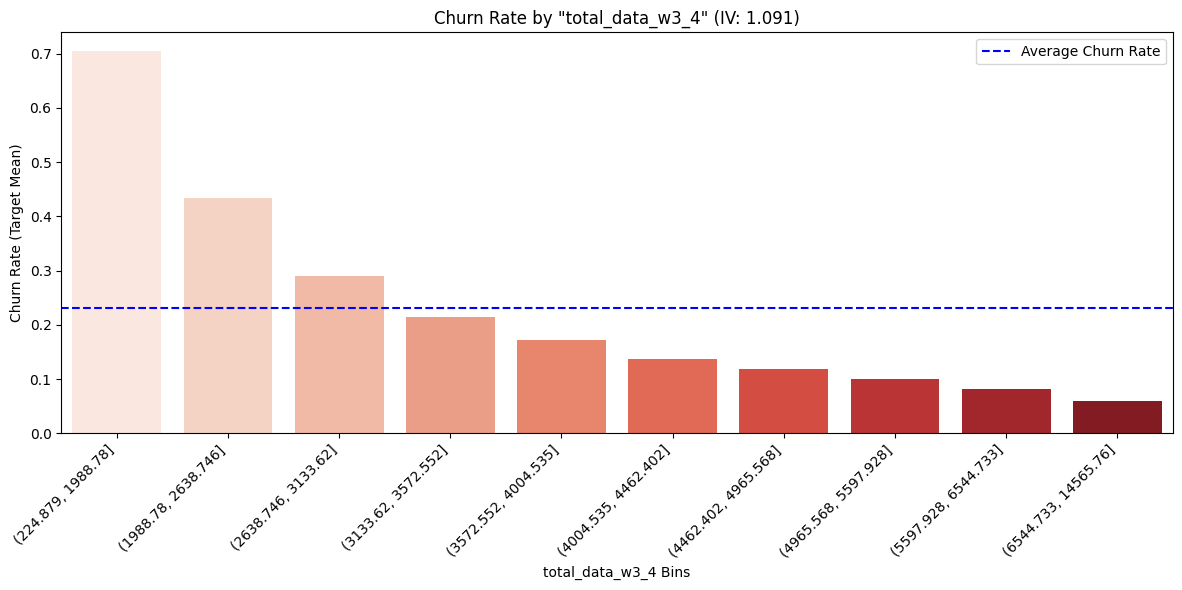

In [26]:
# Plot the #1 "Suspicious" Feature
plot_woe_analysis(train_df, 'total_data_w3_4', 'churn')

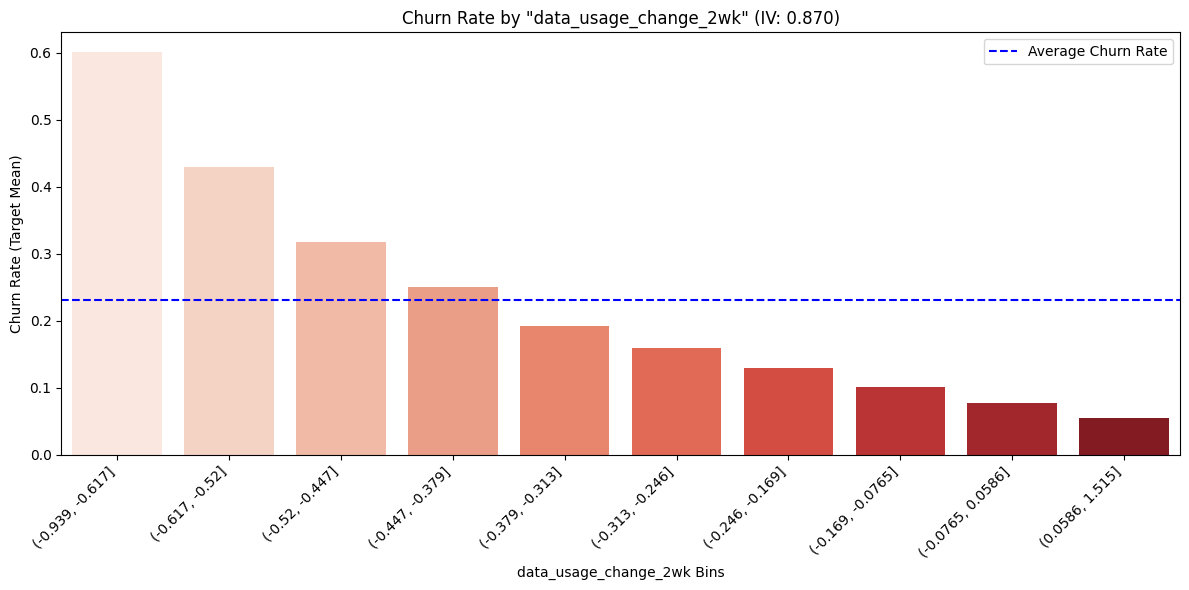

In [27]:
# Plot the #2 Feature (The "Change" Metric)
plot_woe_analysis(train_df, 'data_usage_change_2wk', 'churn')

### Weight of Evidence Analysis Summary
**Objective:** Validate the relationship between high-IV features and churn risk.

**Method:** Analyzed Churn Rate across decile bins for Top Features (`total_data_w3_4` and `data_usage_change_2wk`).

**Key Findings:**
* **Monotonic Trends:** Both features exhibit a clear **"Staircase" pattern**, verifying a monotonic relationship.
    * **Volume:** Higher data usage consistently correlates with lower churn rates across all bins.
    * **Trend:** The `change` metric is highly sensitive; deeper negative changes (drops in usage) correspond to progressively higher churn rates.
* **Interpretation:** This confirms the "Gradual Disengagement" hypothesis (in Section 2.4). Churn is not a sudden event but a measurable decline in engagement during Days 15-28.
* **Modeling Implication:** The linearity of these trends suggests these features will perform exceptionally well in linear models (Logistic Regression) without requiring complex non-linear transformations.

# 2.6 Segmentation via UMAP

Preparing Customer Segmentation Map...
Mapping based on Top 20 Features: ['total_data_w3_4', 'data_usage_change_2wk', 'usage_app_facebook_daily_std_dev_w3_4', 'usage_voice_d2d_incoming_std_dev_w3_4', 'usage_app_whatsapp_daily_std_dev_w3_4', 'usage_pack_vas_std_dev_w3_4', 'usage_app_helakuru_daily_std_dev_w3_4', 'usage_pack_data_std_dev_w3_4', 'usage_voice_d2d_outgoing_std_dev_w3_4', 'usage_app_other_std_dev_w3_4', 'usage_voice_nd2d_incoming_std_dev_w3_4', 'usage_app_tiktok_daily_std_dev_w3_4', 'usage_voice_d2nd_outgoing_std_dev_w3_4', 'usage_app_youtube_daily_std_dev_w3_4', 'usage_pack_vas_median_w1_2', 'video_data_w3_4', 'usage_voice_d2d_incoming_median_w1_2', 'usage_app_youtube_daily_median_w1_2', 'usage_voice_nd2d_incoming_median_w1_2', 'usage_app_other_median_w1_2']


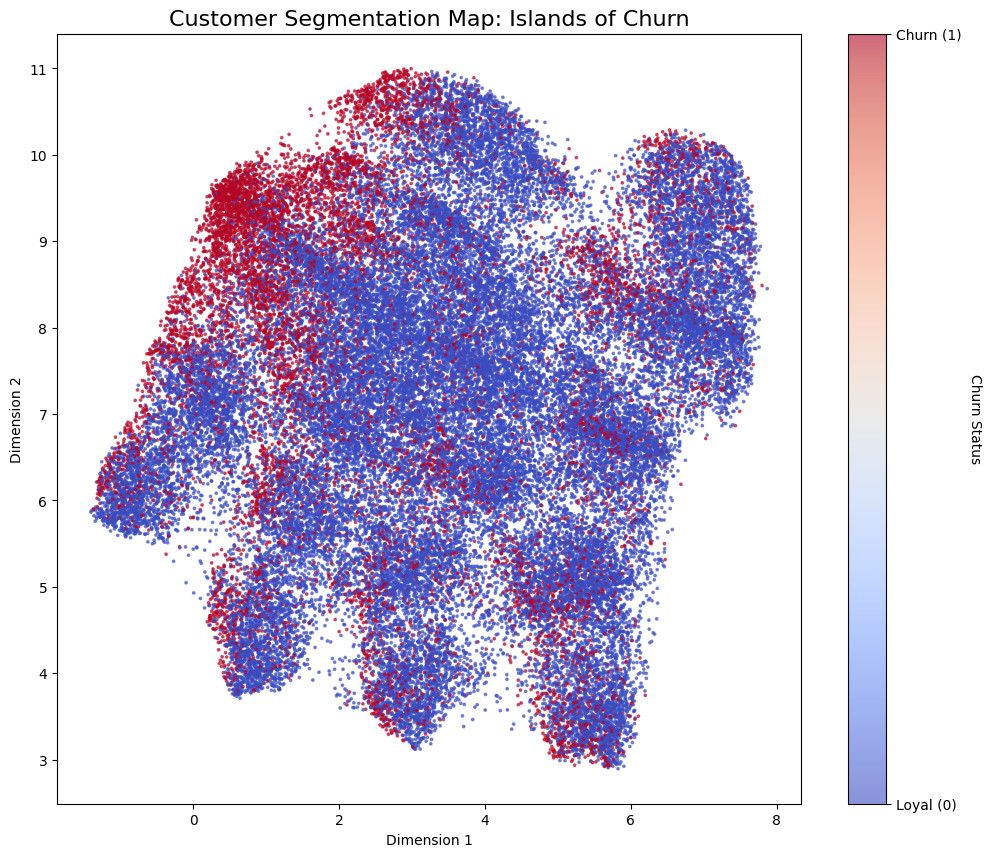

In [19]:
print("Preparing Customer Segmentation Map...")

# Feature Selection: Use the Top 20 features from ySection 2.4
top_20_features = feature_rankings['Feature'].head(20).tolist()
print(f"Mapping based on Top 20 Features: {top_20_features}")

# reprocessing: Scale the data (Critical for UMAP)
X_segmentation = train_df[top_20_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_segmentation)

# Run UMAP Projection
# n_neighbors=30: Balances local clusters with global structure
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(X_scaled)

# Prepare Data for Plotting (The Shuffle Trick)
# Combine the coordinates with the Churn label, then SHUFFLE them.
# This ensures Red dots aren't hidden behind the massive pile of Blue dots.
plot_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
plot_df['churn'] = train_df['churn'].values
plot_df_shuffled = plot_df.sample(frac=1, random_state=42) # Shuffle 100% of rows

# The Final "Money Plot"
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    plot_df_shuffled['UMAP_1'], 
    plot_df_shuffled['UMAP_2'], 
    c=plot_df_shuffled['churn'], 
    cmap='coolwarm',  # Cool (Blue) = 0, Warm (Red) = 1
    s=3,              # Dot size
    alpha=0.6         # Transparency
)

# Formatting
plt.title('Customer Segmentation Map: Islands of Churn', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Custom Legend
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Loyal (0)', 'Churn (1)'])
cbar.set_label('Churn Status', rotation=270, labelpad=15)

plt.show()

In [20]:
# Investigating the 'Red Island'
# Import KMeans
from sklearn.cluster import KMeans

In [22]:
feature_rankings.head(20)

,Feature,IV,RF_Importance
0,total_data_w3_4,1.090522,0.056186
1,data_usage_change_2wk,0.869526,0.035248
2,usage_app_facebook_daily_std_dev_w3_4,0.710239,0.036782
3,usage_voice_d2d_incoming_std_dev_w3_4,0.706992,0.043759
4,usage_app_whatsapp_daily_std_dev_w3_4,0.692356,0.039216
5,usage_pack_vas_std_dev_w3_4,0.688417,0.044435
6,usage_app_helakuru_daily_std_dev_w3_4,0.681002,0.037944
7,usage_pack_data_std_dev_w3_4,0.674751,0.043452
8,usage_voice_d2d_outgoing_std_dev_w3_4,0.672792,0.039046
9,usage_app_other_std_dev_w3_4,0.668664,0.026713


Cluster Profiling Report:
   Cluster_ID     churn  total_data_w3_4  data_usage_change_2wk  \
0           0  0.150535      5033.792712              -0.183766   
1           1  0.171214      4828.604470              -0.216362   
2           2  0.351590      2892.712820              -0.447896   

   usage_app_facebook_daily_std_dev_w3_4  usage_pack_vas_median_w1_2  
0                              65.215180                   18.531982  
1                              91.327842                   20.328052  
2                              51.467790                   17.508364  

The 'Red Island' is Cluster 2.


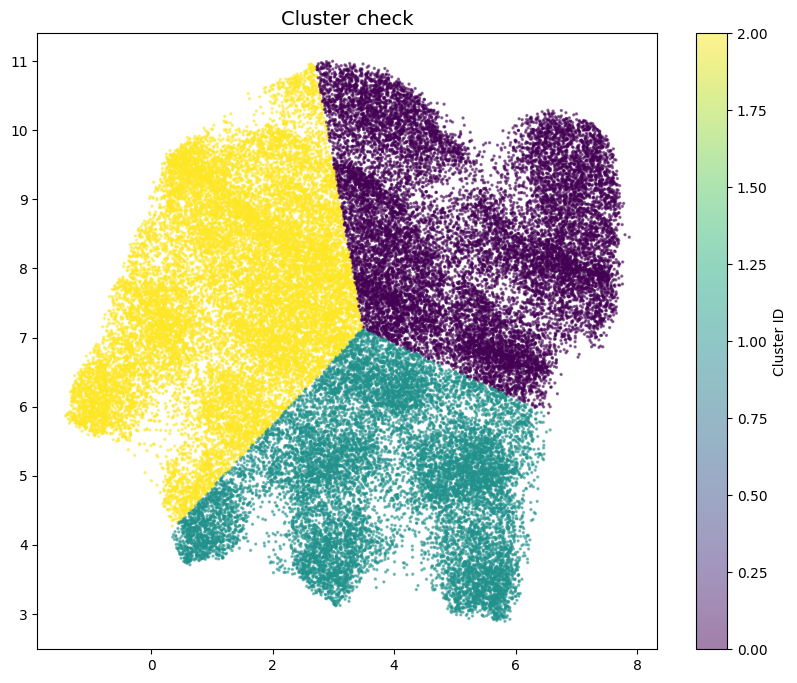

In [24]:
# Cluster the UMAP Map (Use the 'embedding' from the previous step)
# We assume 3 main behaviors: Safe (Blue), Risky (Red Island), and Ambiguous (Middle)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

# Add Cluster IDs to a temporary analysis dataframe
analysis_df = train_df.copy()
analysis_df['Cluster_ID'] = cluster_labels

# Profile the Clusters
# We look at Churn Rate + Top Predictive Features
profiling_cols = ['churn', 'total_data_w3_4', 'data_usage_change_2wk',
                  'usage_app_facebook_daily_std_dev_w3_4', 'usage_pack_vas_median_w1_2']
cluster_stats = analysis_df.groupby('Cluster_ID')[profiling_cols].mean().reset_index()

# Identify the "Red Island" (The cluster with highest churn rate)
red_island_id = cluster_stats.loc[cluster_stats['churn'].idxmax(), 'Cluster_ID']

print("Cluster Profiling Report:")
print(cluster_stats)
print(f"\nThe 'Red Island' is Cluster {red_island_id}.")
# Visual Check: Plot the clusters to confirm they match the UMAP shapes
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', s=2, alpha=0.5)
plt.title(f'Cluster check', fontsize=14)
plt.colorbar(label='Cluster ID')
plt.show()

### Customer Segmentation & Cluster Profiling (UMAP + K-Means)
**Objective:** Visualize high-dimensional customer behavior to isolate high-risk segments and valid the "Disengagement" hypothesis via cluster profiling.

**Method:**
1.  **Projection:** Projected Top 20 predictive features into 2D space using UMAP (`n_neighbors=30`).
2.  **Clustering:** Applied K-Means (k=3) to mathematically profile the visual "Islands."

**Key Findings:**
The analysis successfully isolated a distinct **"High-Risk Island" (Cluster 2)** located in the upper-left quadrant. This segment exhibits a clear behavioral signature distinct from the "Safe" segments (Clusters 0 & 1).

**Cluster 2 Profiling ("The Walking Dead" Segment):**
* **`churn` (Risk Level):** **35.2%**.
    * *Interpretation:* This segment has a churn rate **>2x higher** than the baseline clusters (~15-17%). It represents the primary target for retention efforts.
* **`data_usage_change_2wk` (The Driver):** **-44.8%**.
    * *Interpretation:* This is the "Smoking Gun." While safe customers fluctuated normally (~-18%), this segment slashed their usage by nearly half in the last two weeks. This confirms the **"Early Disengagement"** theory.
* **`total_data_w3_4` (Volume):** **2,892 MB**.
    * *Interpretation:* Significantly lower usage compared to Safe Clusters (~4,800–5,000 MB). The disengagement has already resulted in low total volume by Day 28.
* **`usage_app_facebook_daily_std_dev_w3_4` (Volatility):** **51.47**.
    * *Interpretation:* Lower standard deviation compared to safe users (65–91). This suggests "Consistently Low" or "Flatlining" engagement, rather than the healthy, active variance seen in loyal users.
* **`usage_pack_vas_median_w1_2` (Value Added Services):** **17.51**.
    * *Interpretation:* Slightly lower than safe users (~18–20), but not a primary differentiator. Churn is driven more by **Core Data Disengagement** than by a lack of VAS adoption.

**Actionable Insight:**
The "Red Island" (Cluster 2) is a highly identifiable group of ~35% risk customers who can be detected solely by their **rapid usage decline (-45%)** in Weeks 3-4. Immediate intervention (e.g., "We Miss You" campaigns) is recommended for any customer exhibiting a >40% usage drop-off.

# Strategic Feature Selection: Prioritizing Robustness & Generalizability
**Objective:** Transition from a "Data-Fitting" approach to a "Robust Modeling" approach by restricting the feature space to unit-invariant and platform-agnostic predictors.

**Rationale for Exclusion:**
* **Excluded Absolute Values (e.g., `total_spend`, `total_data`):** These features are sensitive to economic factors (inflation) and service evolution (data cap increases). Including them risks **Model Drift**, where the model becomes obsolete as market prices or usage norms shift.
* **Excluded App-Specific Metrics (e.g., `facebook_daily`):** These introduce **Platform Dependency**. The popularity of specific apps is transient; a robust churn model should detect behavioral patterns (e.g., "Video Consumption") rather than specific app usage.
* **Excluded Diversity Counts (e.g., `distinct_services`):** Validated as low-predictive signals (Low IV) during the EDA phase.

**Selected Feature Subsets (The "Universal" Predictors):**
To ensure the model remains adaptable across different time periods and potentially different Telco operators, the modeling phase will utilize only:
1.  **Temporal Trends (Deltas):** Features measuring the *rate of change* (e.g., `data_usage_change_2wk`). These capture the **velocity of disengagement** regardless of the user's absolute usage level.
2.  **Behavioral Ratios (Profiles):** Features measuring the *composition* of usage (e.g., `pct_data_on_video`). These capture the **style of usage** (e.g., "Heavy Streamer") without relying on raw volume or specific app names.

**Impact:** This strategy may slightly reduce immediate training metrics but significantly enhances the model's lifecycle, stability, and resistance to concept drift.

In [30]:
# Define the robust keywords based on the final decision
# We want columns that represent Ratios (%) and Changes (Deltas)
robust_keywords = ['pct_', 'change_2wk']
cols_to_keep = [col for col in train_df.columns if any(keyword in col for keyword in robust_keywords)]

# Add target back since it was filtered out
cols_to_keep.append('churn')

# Create the Robust Dataset
train_df_final = train_df[cols_to_keep].copy()

print(f"Strategy Executed.")
print(f"Original Feature Count: {train_df.shape[1]}")
print(f"Final Feature Count   :   {train_df_final.shape[1]}")
print("\nRetained Features (The Universal Predictors):")
print(train_df_final.columns.tolist())

Strategy Executed.
Original Feature Count: 139
Final Feature Count   :   8

Retained Features (The Universal Predictors):
['data_usage_change_2wk', 'spend_change_2wk', 'video_data_change_2wk', 'messaging_data_change_2wk', 'pct_data_on_video_w3_4', 'pct_data_on_messaging_w3_4', 'pct_spend_on_vas_w3_4', 'churn']


## Focused EDA on Final Data

In [31]:
# Statistical Summary of Final Dataset
train_df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
data_usage_change_2wk,52004.0,-0.291249,0.266274,-0.938282,-0.482256,-0.313085,-0.126018,1.514833
spend_change_2wk,52004.0,-0.276909,0.464994,-1.000000,-0.631351,-0.358767,0.002372,6.394325
video_data_change_2wk,52004.0,-0.284735,0.399575,-1.000000,-0.580273,-0.341993,-0.046488,3.061199
messaging_data_change_2wk,52004.0,-0.263479,0.566559,-1.000000,-0.698846,-0.368096,0.064877,11.367642
pct_data_on_video_w3_4,52004.0,0.476471,0.191498,0.000000,0.338666,0.477446,0.615940,0.987658
pct_data_on_messaging_w3_4,52004.0,0.031057,0.031863,0.000000,0.010411,0.022746,0.040976,0.558030
pct_spend_on_vas_w3_4,52004.0,0.243310,0.235230,0.000000,0.074099,0.166139,0.331669,1.000000
churn,52004.0,0.231175,0.421588,0.000000,0.000000,0.000000,0.000000,1.000000


In [32]:
# Dataset Info
train_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52004 entries, 0 to 52003
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   data_usage_change_2wk       52004 non-null  float64
 1   spend_change_2wk            52004 non-null  float64
 2   video_data_change_2wk       52004 non-null  float64
 3   messaging_data_change_2wk   52004 non-null  float64
 4   pct_data_on_video_w3_4      52004 non-null  float64
 5   pct_data_on_messaging_w3_4  52004 non-null  float64
 6   pct_spend_on_vas_w3_4       52004 non-null  float64
 7   churn                       52004 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 3.2 MB


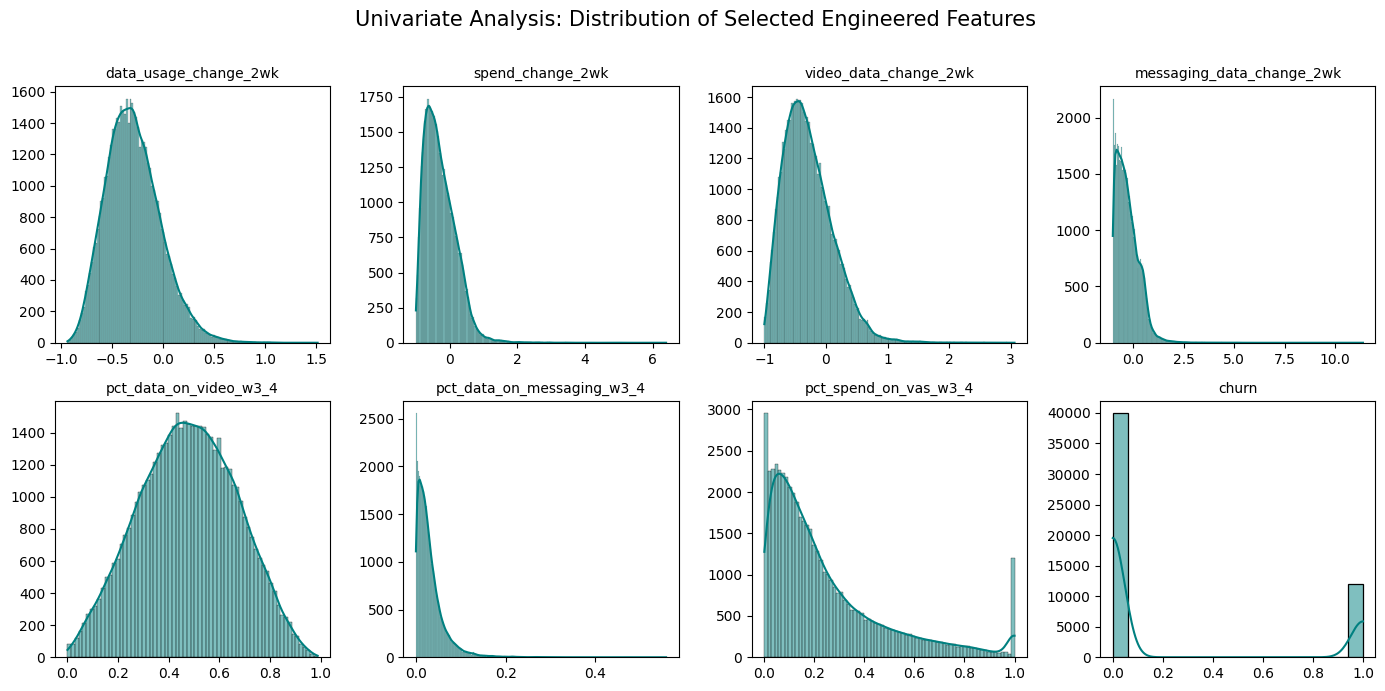

In [33]:
# Visualization: Distribution of Final Features
# Select only the new features columns
feature_columns = train_df_final.columns

# Determine the grid size dynamically
n_cols = 4
n_rows = (len(feature_columns) - 1) // n_cols + 1

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
fig.suptitle('Univariate Analysis: Distribution of Selected Engineered Features', fontsize=15)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot its distribution
for i, col in enumerate(feature_columns):
    ax = axes[i]
    sns.histplot(data=train_df_final, x=col, ax=ax, kde=True, color='teal')
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(feature_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.97]) # Avoid the titles, labels, and plots from overlapping [left, bottom, right, top]
plt.show()

In [40]:
# Create a Function to Generate a Summary Table of Features,
# Checking for Normality and Calculating Outlier Percentages
def univariate_analysis(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in numeric_cols:
        series = df[col]
        total_count = len(series)
        
        # IQR Outlier Detection
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        lower_pct = (series < lower_bound).sum() / total_count * 100
        upper_pct = (series > upper_bound).sum() / total_count * 100

        # Shape Stats
        clean_data = series.dropna()
        
        # Skewness: 0 is symmetrical
        skew_val = clean_data.skew()
        
        # Kurtosis: 0 is normal (Fisher's definition used by Pandas)
        kurt_val = clean_data.kurtosis()

        results.append({
            'Feature': col,
            'Skewness': round(skew_val, 3),
            'Kurtosis': round(kurt_val, 3),
            'Lower Outliers (%)': round(lower_pct, 2),
            'Upper Outliers (%)': round(upper_pct, 2)
        })

    return pd.DataFrame(results)

In [41]:
# Generate the Univariate Summary for the Final Dataset
univariate_summary = univariate_analysis(train_df_final.drop(columns=['churn']))
univariate_summary

,Feature,Skewness,Kurtosis,Lower Outliers (%),Upper Outliers (%)
0,data_usage_change_2wk,0.557,0.550,0.0,1.14
1,spend_change_2wk,1.395,6.122,0.0,1.29
2,video_data_change_2wk,0.931,1.814,0.0,1.32
3,messaging_data_change_2wk,1.737,11.104,0.0,1.39
4,pct_data_on_video_w3_4,-0.026,-0.558,0.0,0.00
5,pct_data_on_messaging_w3_4,3.067,18.348,0.0,5.28
6,pct_spend_on_vas_w3_4,1.491,1.759,0.0,6.25


In [39]:
# Get IV and RF Importance for Final Features
feature_rankings[feature_rankings['Feature'].isin(cols_to_keep)].sort_values(by='IV', ascending=False)

,Feature,IV,RF_Importance
1,data_usage_change_2wk,0.869526,0.035248
28,video_data_change_2wk,0.474030,0.001947
29,spend_change_2wk,0.427455,0.003523
64,messaging_data_change_2wk,0.333696,0.001560
107,pct_data_on_video_w3_4,0.129664,0.001023
113,pct_data_on_messaging_w3_4,0.116223,0.000764
123,pct_spend_on_vas_w3_4,0.086614,0.000686


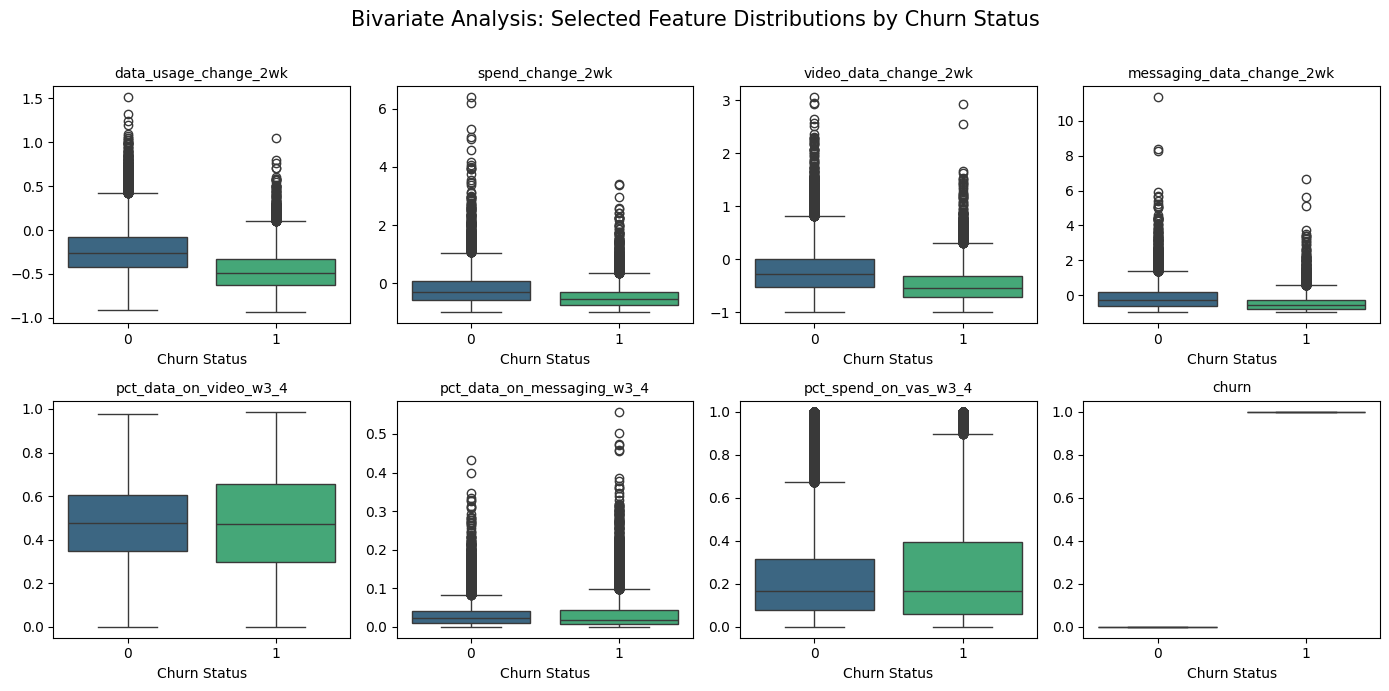

In [43]:
# Visualization: Bivariate Analysis of Features vs Churn
# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
fig.suptitle('Bivariate Analysis: Selected Feature Distributions by Churn Status', fontsize=15)
axes = axes.flatten()

# Loop through each feature and create a box plot
for i, col in enumerate(feature_columns):
    ax = axes[i]
    sns.boxplot(data=train_df_final, x='churn', y=col, ax=ax,
                hue='churn', legend=False, palette='viridis')
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('')

# Remove any empty subplots
for i in range(len(feature_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

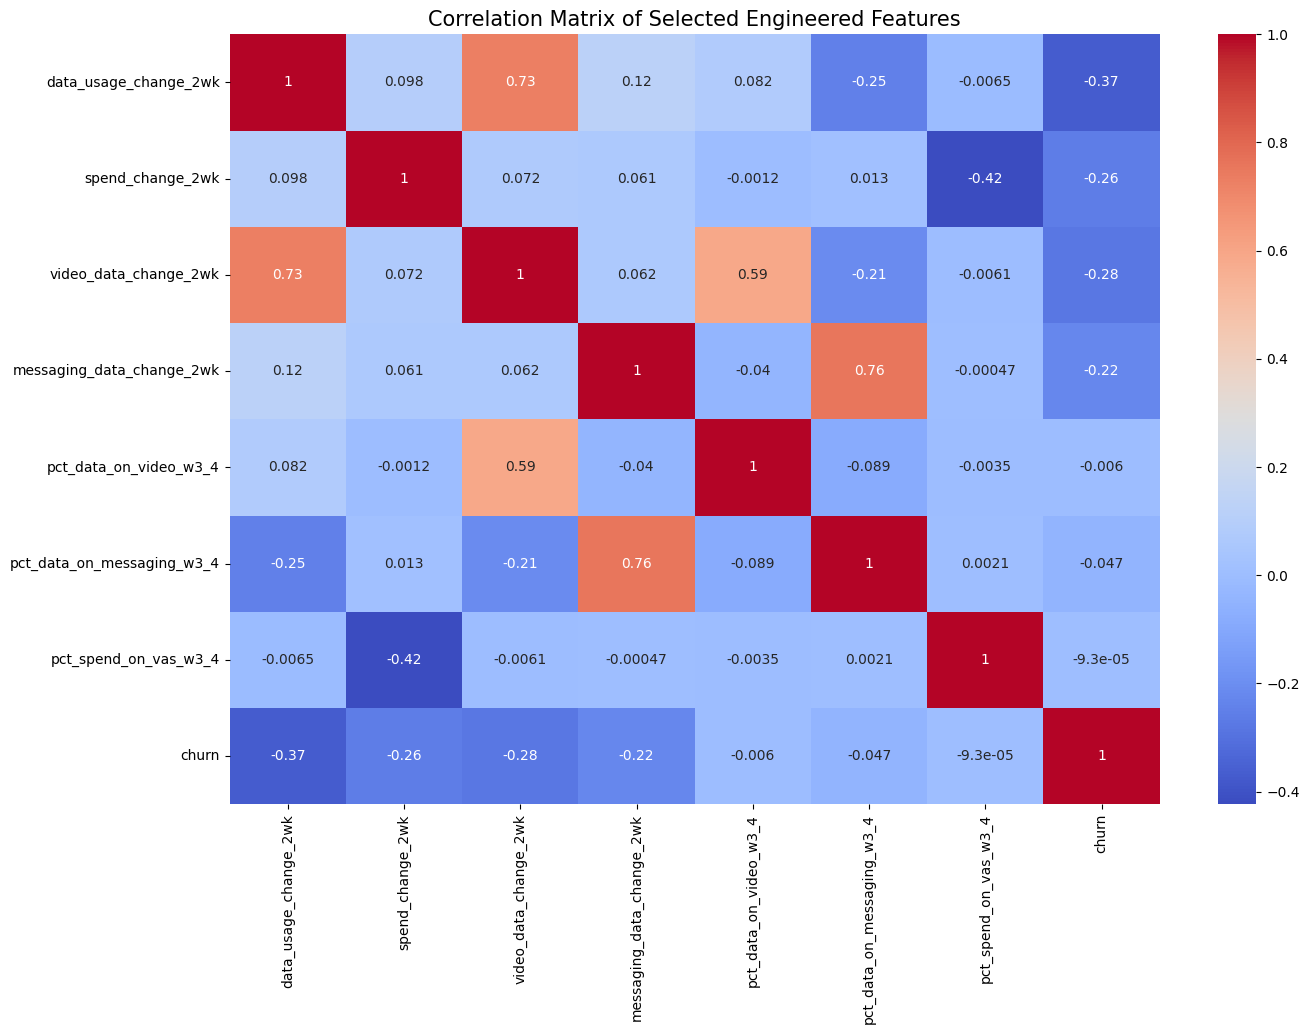

In [47]:
# Multivariate Analysis for Final Dataset
# Correlation Heatmap

# Calculate the correlation matrix for the engineered features
correlation_matrix = train_df_final.corr(method='spearman')

# Create a figure for the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix of Selected Engineered Features', fontsize=15)
plt.show()

### EDA on Selected Features Summary
**Objective:** Validate the statistical properties and predictive stability of the final selected ratio and trend features.

**Statistical Properties & Distribution:**
* **Distribution Shape:** The feature set is predominantly **Non-Normal**. Most features are right-skewed and **Leptokurtic** (sharp peak, heavy tails), indicating user behavior is clustered around a baseline with frequent deviations.
    * *Exception:* `pct_data_on_video_w3_4` exhibits a near-Gaussian (Normal) distribution, suggesting video consumption ratios are relatively standardized across the user base.
* **Outliers:** Outliers are present but manageable, affecting approximately **1%** of samples. Standard robust scaling methods (e.g., RobustScaler) will effectively handle these without data loss.

**Predictive Power & Behavior:**
* **Signal Validation:** `data_usage_change_2wk` retains a high Information Value (IV > 0.5), reaffirming the **"Walking Dead"** hypothesis (Early Disengagement) as a legitimate, dominant churn signal rather than a data artifact.
* **Volatility Signal:** Boxplot analysis reveals that Churners exhibit significantly higher **behavioral inconsistency** (erratic variance) regarding Video Data Ratios compared to Non-Churners. This volatility itself is a predictive feature.
* **Weak Predictors:** `pct_spend_on_vas_w3_4` demonstrates weak discriminative power. It is flagged as a candidate for removal during the final model selection phase.

**Correlations:**
* **Multicollinearity:** Strong correlations persist among certain trend features. These will be retained for the moment and resolved during the modeling phase.